In [1]:
### インポート

# 数値・確率計算
import pandas as pd
import numpy as np
import scipy.stats as stats

# PyMC
import pymc as pm
import pytensor.tensor as pt
import arviz as az

# 描画
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
# plt.rcParams['font.family'] = 'Meiryo'

# ワーニング表示の抑制
import warnings
warnings.simplefilter('ignore')

In [3]:
### データの読み込み ◆データファイル5.1 data-attendance-1.txtの構成
# A:バイト好き区分(1:好き), Score:学問の興味の強さ（0~200）, Y:授業の出席率（1年間）

data = pd.read_csv('./input/data-attendance-1.txt')
print('data.shape: ', data.shape)
display(data.head())

data.shape:  (50, 3)


,A,Score,Y
0,0,69,0.286
1,1,145,0.196
2,0,125,0.261
3,1,86,0.109
4,1,158,0.230


# 分析の目的
- ２つの説明変数$A$と$Score$で応答変数$Y$がどれほど予測できるか知りたい
- それぞれの説明変数が出席率にどれほど影響しているかを知りたい

この解析結果を発表する場合、聴衆を納得させるにはどういう図を描いて発表資料を作成するべき？

## データ分布の確認

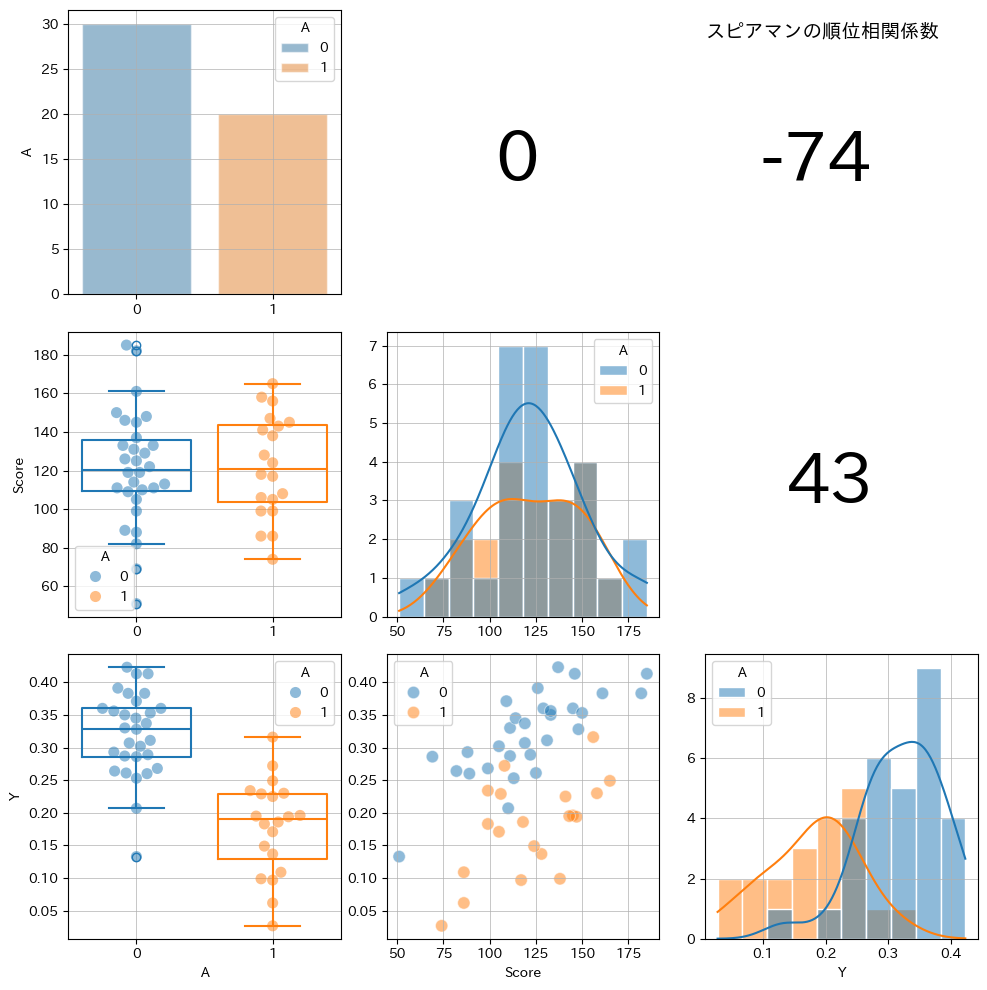

In [4]:
### 散布図行列の描画 ◆図5.1
# 凡例非表示・・・描画関数の引数に legend=None を追加する

## 描画領域の指定
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
ax = ax.ravel() # １次元でaxesを指定したいので

## 番地0,0：ヒストグラムの描画（棒グラフを使用）
bar_A = data.A.value_counts().sort_index()
sns.barplot(ax=ax[0], x=bar_A.index, y=bar_A, hue=bar_A.index, palette='tab10',
            alpha=0.5, ec='white')
ax[0].set(ylabel='A', xlabel=None)
ax[0].grid(lw=0.5)

## 番地0,1：スピアマンの順位相関係数の描画
ax[1].set_axis_off()
corr1, pval1 = stats.spearmanr(data.Score, data.A)
ax[1].text(x=0.4, y=0.4, s=round(corr1 * 100), fontsize=50)

## 番地0,2：スピアマンの順位相関係数の描画
ax[2].set_axis_off()
corr2, pval2 = stats.spearmanr(data.Y, data.A)
ax[2].text(x=0.2, y=0.4, s=round(corr2 * 100), fontsize=50)
ax[2].text(x=0, y=0.9, s='スピアマンの順位相関係数', fontsize=14)

## 番地1,0：箱ひげ図＋スウォームプロットの描画
sns.boxplot(ax=ax[3], x=data.A, y=data.Score, hue=data.A, fill=False,
            legend=None)
sns.swarmplot(ax=ax[3], x=data.A, y=data.Score, hue=data.A, size=8, alpha=0.5)
ax[3].set(xlabel=None)
ax[3].grid(lw=0.5)

## 番地1,1：ヒストグラムの描画
sns.histplot(ax=ax[4], data=data, x='Score', hue='A', bins=10, kde=True, 
             ec='white')
ax[4].set(xlabel=None, ylabel=None)
ax[4].grid(lw=0.5)

## 番地1,2：スピアマンの順位相関係数の描画
ax[5].set_axis_off()
corr3, pval3 = stats.spearmanr(data.Y, data.Score)
ax[5].text(x=0.3, y=0.4, s=round(corr3 * 100), fontsize=50)

## 番地2,0：箱ひげ図＋スウォームプロットの描画
sns.boxplot(ax=ax[6], x=data.A, y=data.Y, hue=data.A, fill=False,
            legend=None)
sns.swarmplot(ax=ax[6], x=data.A, y=data.Y, hue=data.A, size=8, alpha=0.5)
ax[6].grid(lw=0.5)

## 番地2,1：散布図の描画
sns.scatterplot(ax=ax[7], data=data, x='Score', y='Y', hue='A', size='A',
                sizes=(80, 80), alpha=0.5)
ax[7].set(ylabel=None)
ax[7].grid(lw=0.5)

## 番地2,2：ヒストグラムの描画
sns.histplot(ax=ax[8], data=data, x='Y', hue='A', bins=10, kde=True, ec='white')
ax[8].set(ylabel=None)
ax[8].grid(lw=0.5)

plt.tight_layout();

- scoreとYには線形関係がありそう。Aに関わらず。
- A=0/1の違いで、Yは如実に変わる。
→ AとScoreの線型結合でYが決まりそう（仮定・仮説）
  
$$
Y = b_1 + b_2A[n] + b_3Score[n] + \epsilon[n] 
$$

In [10]:
with pm.Model() as model:
    model.add_coord("data", values=data.index, mutable=True)

    Y = pm.ConstantData("Y", value=data["Y"].values, dims="data")
    A = pm.ConstantData("A", value=data["A"].values, dims="data")
    Score = pm.ConstantData("Score", value=data["Score"].values / 200, dims="data")

    ### prior
    b1 = pm.Uniform("b1", lower=-10, upper=10)
    b2 = pm.Uniform("b2", lower=-10, upper=10)
    b3 = pm.Uniform("b3", lower=-10, upper=10)
    sigma = pm.Uniform("sigma", lower=0, upper=10)    # pm.HalfNormalでもいいはず

    ### 線形予測子
    mu = pm.Deterministic("mu", b1+b2*A+b3*Score, dims="data")

    ### 尤度関数
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=Y, dims="data")   ##← dims="data"忘れがち

    ### 計算値
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, dims="data")

# display(model)


    b1 ~ Uniform(-10, 10)
    b2 ~ Uniform(-10, 10)
    b3 ~ Uniform(-10, 10)
 sigma ~ Uniform(0, 10)
y_pred ~ Normal(mu, sigma)
    mu ~ Deterministic(f(b3, b1, b2))
   obs ~ Normal(mu, sigma)

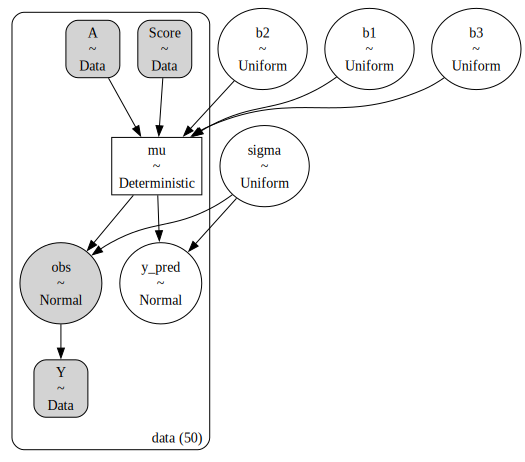

In [11]:
g = pm.model_to_graphviz(model)
display(g)